In [2]:
# set up Python environment: numpy for numerical routines, and matplotlib for plotting
import numpy as np
import matplotlib.pyplot as plt
# display plots in this notebook
%matplotlib inline

# set display defaults
plt.rcParams['figure.figsize'] = (10,10)         # large images
plt.rcParams['image.interpolation'] = 'nearest'  # don't interpolate: show square pixels
plt.rcParams['image.cmap'] = 'gray'              # use grayscale output rather than a (potentially misleading) color heatmap

In [3]:
# The caffe module needs to be on the Python path;
#  we'll add it here explicitly.
import sys
caffe_root = 'C:/Users/CHENTIEJUN/Anaconda3/envs/caffe/Lib/site-packages/caffe'
sys.path.insert(0,caffe_root+'python')

import caffe
# If you get "No module named _caffe", either you have not built pycaffe or you have the wrong path.

In [4]:
import os
if os.path.isfile(caffe_root + '/bvlc_reference_caffenet/bvlc_reference_caffenet.caffemodel'):
    print ('CaffeNet found.')
else:
    print ('Downloading pre-trained CaffeNet model...')
    !../scripts/download_model_binary.py ../models/bvlc_reference_caffenet

CaffeNet found.


In [5]:
caffe.set_mode_cpu()

model_def = caffe_root + '/bvlc_reference_caffenet/solver.prototxt'
model_weights = caffe_root + '/bvlc_reference_caffenet/bvlc_reference_caffenet.caffemodel'

net = caffe.Net(model_def,      # defines the structure of the model
               model_weights,   # contains the trained weights
               caffe.TEST)      # use test mode (e.g., don't perform dropout)

In [6]:
# load the mean ImageNet image (as distributed with Caffe) for subtraction
mu = np.load(caffe_root + '/imagenet/ilsvrc_2012_mean.npy')
mu = mu.mean(1).mean(1)  # average over pixels to obtain the mean (BGR) pixel values
print('mean-subtracted values:',zip('BGR', mu))
print(mu)

# create transformer for the input called 'data'
transformer = caffe.io.Transformer({'data': net.blobs['data'].data.shape})

transformer.set_transpose('data', (2,0,1))  # move image channels to outermost dimension
transformer.set_mean('data', mu)            # subtract the dataset-mean value in each channel
transformer.set_raw_scale('data', 255)      # rescale from [0, 1] to [0, 255]
transformer.set_channel_swap('data', (2,1,0))  # swap channels from RGB to BGR

mean-subtracted values: <zip object at 0x0000022439281E08>
[104.00698793 116.66876762 122.67891434]


In [7]:
# set the size of the input (we can skip this if we're happy
#  with the default; we can also change it later, e.g., for different batch sizes)
net.blobs['data'].reshape(50,        # batch size
                          3,         # 3-channel (BGR) images
                          227, 227)   # image size is 227x227

[[[ 56.69728   58.558624  61.11856  ...  87.67143   87.67143   87.67143 ]
  [ 52.789917  54.778564  56.76599  ...  85.02826   85.02826   85.02826 ]
  [ 50.349854  51.76599   53.189056 ...  83.99301   83.99301   83.99301 ]
  ...
  [ 63.059784  62.385086  62.385086 ... 103.581116 104.09874  104.581116]
  [ 65.54588   65.54588   65.12973  ... 108.06349  108.31319  108.54588 ]
  [ 69.510635  69.10582   68.54216  ... 112.346115 111.67143  110.96716 ]]

 [[ 38.035503  39.896847  42.456783 ...  80.00965   80.00965   80.00965 ]
  [ 34.12814   36.116802  38.104214 ...  77.36648   77.36648   77.36648 ]
  [ 31.688074  33.104214  34.52728  ...  76.33123   76.33123   76.33123 ]
  ...
  [ 45.398006  44.72331   44.72331  ...  82.919334  83.43696   83.919334]
  [ 47.884106  47.884106  47.467953 ...  87.40171   87.651405  87.8841  ]
  [ 51.848858  51.444042  50.880383 ...  91.68433   91.00965   90.30538 ]]

 [[ 33.025356  34.8867    37.446636 ...  64.999504  64.999504  64.999504]
  [ 29.11799   31.1066

C:\Users\CHENTIEJUN\Anaconda3\envs\caffe\lib\site-packages\skimage\io\_io.py:49: UserWarning: `as_grey` has been deprecated in favor of `as_gray`
  warn('`as_grey` has been deprecated in favor of `as_gray`')
C:\Users\CHENTIEJUN\Anaconda3\envs\caffe\lib\site-packages\skimage\transform\_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\CHENTIEJUN\Anaconda3\envs\caffe\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


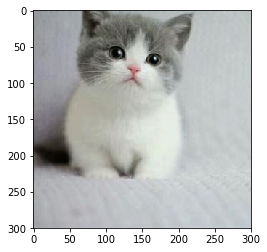

In [8]:
image = caffe.io.load_image(caffe_root + '/images/cat.jpg')
transformed_image = transformer.preprocess('data', image)
plt.imshow(image)
print(transformed_image)

In [9]:
# copy the image data into the memory allocated for the net
net.blobs['data'].data[...] = transformed_image

### perform classification
output = net.forward()

output_prob = output['prob'][0]  # the output probability vector for the first image in the batch

print('predicted class is:', output_prob.argmax())

predicted class is: 283


In [10]:
# load ImageNet labels
labels_file = caffe_root + '/imagenet/synset_words.txt'
if not os.path.exists(labels_file):
    !../data/ilsvrc12/get_ilsvrc_aux.sh
    
labels = np.loadtxt(labels_file, str, delimiter='\t')

print('output label:', labels[output_prob.argmax()])

output label: n02123394 Persian cat


In [11]:
# sort top five predictions from softmax output
top_inds = output_prob.argsort()[::-1][:5]  # reverse sort and take five largest items

for i in top_inds:
    print('probabilities and labels:',(output_prob[i], labels[i]))

probabilities and labels: (0.32837626, 'n02123394 Persian cat')
probabilities and labels: (0.24451935, 'n02127052 lynx, catamount')
probabilities and labels: (0.20881109, 'n02124075 Egyptian cat')
probabilities and labels: (0.12316658, 'n02123045 tabby, tabby cat')
probabilities and labels: (0.01701607, 'n02342885 hamster')


In [13]:
for layer_name, blob in net.blobs.items():
    print(layer_name + '/t'+str(blob.data.shape))

data/t(50, 3, 227, 227)
conv1/t(50, 96, 55, 55)
pool1/t(50, 96, 27, 27)
norm1/t(50, 96, 27, 27)
conv2/t(50, 256, 27, 27)
pool2/t(50, 256, 13, 13)
norm2/t(50, 256, 13, 13)
conv3/t(50, 384, 13, 13)
conv4/t(50, 384, 13, 13)
conv5/t(50, 256, 13, 13)
pool5/t(50, 256, 6, 6)
fc6/t(50, 4096)
fc7/t(50, 4096)
fc8/t(50, 1000)
prob/t(50, 1000)


In [14]:
for layer_name,param in net.params.items():
    print(layer_name + '/t'+str(param[0].data.shape),str(param[1].data.shape))

conv1/t(96, 3, 11, 11) (96,)
conv2/t(256, 48, 5, 5) (256,)
conv3/t(384, 256, 3, 3) (384,)
conv4/t(384, 192, 3, 3) (384,)
conv5/t(256, 192, 3, 3) (256,)
fc6/t(4096, 9216) (4096,)
fc7/t(4096, 4096) (4096,)
fc8/t(1000, 4096) (1000,)
